## Install PyGeNN wheel from Google Drive
Download wheel file

In [1]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1fllqUtL_1_tyGzjNHSR-9i5fXFI9jqAi'

output = 'pygenn-4.8.1-cp310-cp310-linux_x86_64.whl'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fllqUtL_1_tyGzjNHSR-9i5fXFI9jqAi
To: /kaggle/working/pygenn-4.8.1-cp310-cp310-linux_x86_64.whl
100%|██████████| 22.3M/22.3M [00:00<00:00, 183MB/s]


'pygenn-4.8.1-cp310-cp310-linux_x86_64.whl'

and then install PyGeNN from wheel file

In [3]:
pip install pygenn-4.8.1-cp310-cp310-linux_x86_64.whl

Processing ./pygenn-4.8.1-cp310-cp310-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


and checkout mlGeNN from git and install

In [4]:
!git clone https://github.com/genn-team/ml_genn.git
%pushd ml_genn
!git checkout 983400ba
!pip install ./ml_genn
%popd

Cloning into 'ml_genn'...
remote: Enumerating objects: 6804, done.
remote: Counting objects: 100% (2621/2621), done.
remote: Compressing objects: 100% (995/995), done.
remote: Total 6804 (delta 1637), reused 2507 (delta 1599), pack-reused 4183
Receiving objects: 100% (6804/6804), 37.14 MiB | 18.89 MiB/s, done.
Resolving deltas: 100% (4482/4482), done.
/kaggle/working/ml_genn
Note: switching to '983400ba'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 983400b softmax is required for eprop validation split
Proc

Set environment variable to allow GeNN to find CUDA

In [5]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


## Load oneshot classification data from Onimiglot

## Process data

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from ml_genn import InputLayer, Layer, SequentialNetwork
from ml_genn.callbacks import Checkpoint
from ml_genn.compilers import EventPropCompiler, InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.initializers import Normal
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput
from ml_genn.optimisers import Adam
from ml_genn.serialisers import Numpy
from ml_genn.synapses import Exponential

from ml_genn.utils.data import (calc_latest_spike_time, linear_latency_encode_data)

from ml_genn.compilers.event_prop_compiler import default_params

In [8]:
data_url = '/kaggle/input/one-shot-classification'

In [9]:
from PIL import Image
import os

def load_images(path):
    # Lists to store the images and labels
    train_images, train_labels, test_images, test_labels = [], [], [], []

    # List of all directories
    dir_list = os.listdir(path)
    
    # for one file.
    count = 0
    # For each directory
    for dir in dir_list:
        if (count == 1):
            break
        print(dir)
        count += 1

        # Load the mapping of test images to class labels
        with open(path + '/' + dir + '/class_labels.txt', 'r') as f:
            labels_map = {line.split()[0]: line.split()[1] for line in f.readlines()}
        # Load and preprocess the training images
        train_list = os.listdir(path + '/' + dir + '/training')
        for img_name in train_list:
            image = Image.open(path + '/' + dir + '/training/' + img_name)
           
            image = image.resize((28, 28))
            image = image.convert('L')  # Convert image to grayscale
            image = np.array(image)
#             print(image)
            image = np.where(image > 128, 0, 255)  # Binarize image with new scale range
            train_images.append(image)
            train_labels.append(img_name)  # The image name is the class label

        # Load and preprocess the test images
        test_list = os.listdir(path + '/' + dir + '/test')
        for img_name in test_list:
            image = Image.open(path + '/' + dir + '/test/' + img_name)
            image = image.resize((28, 28))
            image = image.convert('L')  # Convert image to grayscale
            image = np.array(image)
            image = np.where(image > 128, 0, 255)  # Binarize image with new scale range
            test_images.append(image)
            test_labels.append(labels_map[dir + '/test/' + img_name])  # Look up the class label in the labels map with the correct key

    # Convert the lists to numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    # Extract the class numbers from the labels
    test_labels = np.array([int(label.split('/')[-1].split('.')[0][5:]) for label in test_labels])

    # Convert the class numbers to uint8 data type
    test_labels = test_labels.astype(np.uint8)
    
    # Extract the class numbers from the labels
    train_labels = np.array([int(label.split('/')[-1].split('.')[0][5:]) for label in train_labels])

    # Convert the class numbers to uint8 data type
    train_labels = train_labels.astype(np.uint8)


    return train_images, train_labels, test_images, test_labels


In [10]:
train_images, train_labels, test_images, test_labels = load_images(data_url)

run12


In [11]:
def expand_data(train_images, train_labels):
    expanded_train_images = np.repeat(train_images, 100, axis=0)
    expanded_train_labels = np.repeat(train_labels, 100, axis=0)
    return expanded_train_images, expanded_train_labels

# Usage example
# train_images, train_labels, test_images, test_labels = load_images(path)
train_images, train_labels = expand_data(train_images, train_labels)


In [12]:
print(len(train_images[0]))
print(len(train_images[0][0]))
print(train_images[0])
len(train_images)

28
28
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 

2000

In [13]:
print(len(test_images[0]))
print(len(test_images[0][0]))
test_images

28
28


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [14]:
train_labels

array([16, 16, 16, ...,  4,  4,  4], dtype=uint8)

In [15]:
test_labels

array([ 9, 16,  8, 12,  6,  4, 10, 13, 19,  3, 14,  7,  2, 18,  5, 11, 17,
       15,  1, 20], dtype=uint8)

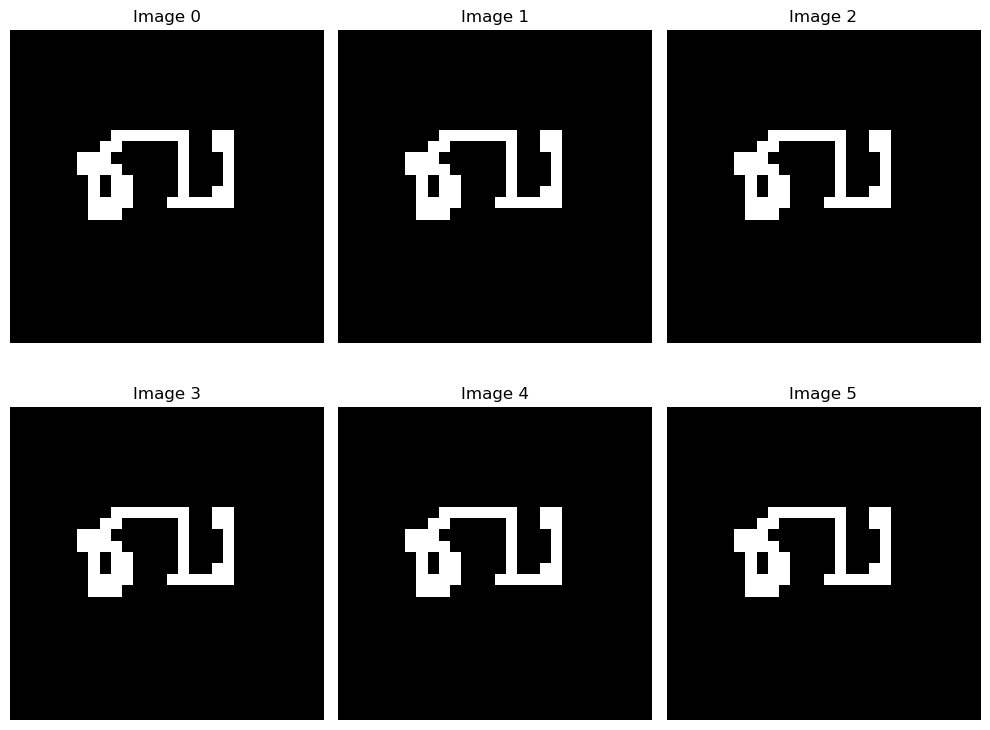

In [16]:
# import cv2
# Define the number of rows and columns in the grid
num_rows = 2
num_cols = 3

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

# Iterate through the images and plot them in the grid
for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(f"Image {i}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Build modle


##Parameters

Define some model parameters


In [17]:
NUM_INPUT = 28 * 28
NUM_HIDDEN = 128
NUM_OUTPUT = 20
BATCH_SIZE = 128

## Latency encoding
There are numerous ways to encode images using spikes but here we are going to emit a single spike for each neuron at a time proportional the each pixel's grayscale.

In [18]:
train_spikes = linear_latency_encode_data(train_images, 20.0)
# print(train_spikes)

## Network definition
Because our network is entirely feedforward, we can define it as a ``SequentialNetwork`` where each layer is automatically connected to the previous layer. As we have converted the MNIST dataset to spikes, we will use a ``SpikeInput`` to inject these directly into the network. For our hidden layer we are going to use standard Leaky integrate-and-fire neurons. Finally, we are going to use a non-spiking output layer and read classifications out of this by determening the maximum of the output neurons' averaged membrane voltages.



In [19]:
# Create sequential model
serialiser = Numpy("latency_mnist_checkpoints")
network = SequentialNetwork(default_params)
with network:
    # Populations
    input = InputLayer(SpikeInput(max_spikes=BATCH_SIZE * NUM_INPUT),
                                  NUM_INPUT)
    hidden = Layer(Dense(Normal(mean=0.078, sd=0.045)), 
               LeakyIntegrateFire(v_thresh=1.0, tau_mem=25.0,  # changed v_thresh and tau_mem
                                  tau_refrac=None),
                                   NUM_HIDDEN, Exponential(5.0))

    output = Layer(Dense(Normal(mean=0.2, sd=0.37)),
                   LeakyIntegrate(tau_mem=20.0, readout="avg_var"),
                   NUM_OUTPUT, Exponential(5.0))

## Compilation
In mlGeNN, in order to turn an abstract network description into something that can actually be used for training or inference you use a *compiler* class. Here, we use the ``EventPropCompiler`` to train with EventProp and specify batch size and how many timesteps to evaluate each example for as well as choosing our optimiser and loss function. Because this is a classification task, we want to use cross-entropy loss and, because our labels are specified in this way (rather than e.g. one-hot encoded), we use the sparse catgorical variant.

In [20]:
compiler = EventPropCompiler(example_timesteps=20,
                         losses="sparse_categorical_crossentropy",
                         optimiser=Adam(1e-2), batch_size=BATCH_SIZE)
compiled_net = compiler.compile(network)

# Training
Now we will train the model for 10 epochs using our compiled network. To verify its performance we take 10% of the training data as a validation split and add an additional callback to checkpoint weights every epoch.



In [21]:
with compiled_net:
    # Evaluate model on numpy dataset
    callbacks = ["batch_progress_bar", Checkpoint(serialiser)]
    compiled_net.train({input: train_spikes},
            {output:train_labels},
            num_epochs=40, shuffle=True,
            validation_split=0.1,
            callbacks=callbacks)

./EventPropCompiler_CODE/synapseUpdateCUDAOptim.cc(59): warning #177-D: variable "shLg" was declared but never referenced

./EventPropCompiler_CODE/customUpdateCUDAOptim.cc(423): warning #177-D: variable "batchOffset" was declared but never referenced

./EventPropCompiler_CODE/neuronUpdateCUDAOptim.cc(172): warning #177-D: variable "lYTrue" was declared but never referenced

./EventPropCompiler_CODE/neuronUpdateCUDAOptim.cc(192): warning #177-D: variable "backT" was declared but never referenced

./EventPropCompiler_CODE/neuronUpdateCUDAOptim.cc(172): warning #177-D: variable "lYTrue" was declared but never referenced

./EventPropCompiler_CODE/synapseUpdateCUDAOptim.cc(59): warning #177-D: variable "shLg" was declared but never referenced

./EventPropCompiler_CODE/neuronUpdateCUDAOptim.cc(192): warning #177-D: variable "backT" was declared but never referenced

./EventPropCompiler_CODE/customUpdateCUDAOptim.cc(423): warning #177-D: variable "batchOffset" was declared but never referenc

make: Entering directory '/kaggle/working/EventPropCompiler_CODE'


customUpdate.cc(423): warning #177-D: variable "batchOffset" was declared but never referenced

neuronUpdate.cc(172): warning #177-D: variable "lYTrue" was declared but never referenced

neuronUpdate.cc(192): warning #177-D: variable "backT" was declared but never referenced

synapseUpdate.cc(59): warning #177-D: variable "shLg" was declared but never referenced



make: Leaving directory '/kaggle/working/EventPropCompiler_CODE'


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

## Evaluate


Load weights checkpointed from last epoch:

In [22]:
network.load((14,), serialiser)

In [23]:
compiler = InferenceCompiler(evaluate_timesteps=20,
                             reset_in_syn_between_batches=True,
                             batch_size=BATCH_SIZE)
compiled_net = compiler.compile(network)

In [24]:
test_spikes = linear_latency_encode_data(test_images, 20.0)
with compiled_net:
    compiled_net.evaluate({input: test_spikes},
                          {output:test_labels})

./InferenceCompiler_CODE/synapseUpdateCUDAOptim.cc(49): warning #177-D: variable "synBatchOffset" was declared but never referenced

./InferenceCompiler_CODE/synapseUpdateCUDAOptim.cc(49): warning #177-D: variable "synBatchOffset" was declared but never referenced



make: Entering directory '/kaggle/working/InferenceCompiler_CODE'


synapseUpdate.cc(49): warning #177-D: variable "synBatchOffset" was declared but never referenced



make: Leaving directory '/kaggle/working/InferenceCompiler_CODE'


  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
print(test_labels)

[ 9 16  8 12  6  4 10 13 19  3 14  7  2 18  5 11 17 15  1 20]
